#### TOC
1. Anomalies in Data, and cleaning action & explaination. 15 pts
2. Pairwise Corralation Table and explaition. 10 pts
3. Average records stockID vs Day, 25 pts
    - a. autocorrelation, 10 pts
    - b. measure the distance, 5 pts
    - c. clustering algorithm, 10 pts
4. Closing trajectory of stocks on each day highly correlated, 25 pts
   - a. Make three plots, 10 pts
   - b. permutation test to determine the statistical confidence, 15 pts
      p-value
5. Best prediction model, any approaches, 25 pts
6. submit model on Kaggle, 0 pts

#### Start
- Copy this notebook.
  In Google Colab use `File -> Save a Copy in Drive`.
- Use the "Text" blocks to provide explanations wherever you find them necessary.
- Highlight your answers inside these text fields to ensure that we don't miss it
while grading your HW.

#### Setup

- Code to download the data directly from the colab notebook.
- If you find it easier to download the data from the kaggle website (and
uploading it to your drive), you can skip this section.

In [6]:
## First mount your drive before running analysis code
from google.colab import drive
drive.mount('/content/drive')

## Create a folder for the this HW and change to that dir
%cd /content/drive/MyDrive/cse519/optiver-trading-at-the-close


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/cse519/optiver-trading-at-the-close


In [7]:
## packages
!pip install -q kaggle
!pip install -q pandas
!pip install -q scikit-learn
!pip install -q numpy
!pip install -q Matplotlib
!pip install -q seaborn
!pip install -q kneed

In [8]:
## Upload the file by clicking on the browse
# from google.colab import files
# files.upload()

## Create a new API token under "Account" in the kaggle webpage and download the json file

In [9]:
# !mkdir ~/.kaggle
# !cp kaggle.json ~/.kaggle/

# !kaggle competitions download -c optiver-trading-at-the-close
# !unzip optiver-trading-at-the-close.zip
!ls

example_test_files  optiver2023  public_timeseries_testing_util.py  train.csv


#### Q1: Anomalies and Cleaning, 15 pts

Take a look at the training data. There may be anomalies in the data that you may need to factor in before you start on the other tasks. Make a note of the anomalies that you notice. Clean the data first to handle these issues if it will improve your analysis. Explain what you did to clean the data (in bulleted form) or explain why you did not change it to address these anomalies.


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

col_names = [
  "stock_id",
  "date_id",
  "seconds_in_bucket",
  "imbalance_size",
  "imbalance_buy_sell_flag",
  "reference_price",
  "matched_size",
  "far_price",
  "near_price",
  "bid_price",
  "bid_size",
  "ask_price",
  "ask_size",
  "wap",
  "target",
  "time_id",
  "row_id"
]
dtypes = {
  "stock_id":int,
  "date_id":int,
  "seconds_in_bucket":int,
  "imbalance_size":np.float64,
  "imbalance_buy_sell_flag":int,
  "reference_price":np.float64,
  "matched_size":np.float64,
  "far_price":np.float64,
  "near_price":np.float64,
  "bid_price":np.float64,
  "bid_size":np.float64,
  "ask_price":np.float64,
  "ask_size":np.float64,
  "wap":np.float64,
  "target":np.float64,
  "time_id":int,
  "row_id": "string",
}
df_train = pd.read_csv("train.csv")




In the following function, we aim to gain a comprehensive understanding of the dataset. While it shares similarities with the df.info() or df.describe() methods, it provides a wealth of additional and insightful information, making it a valuable tool for data exploration and analysis.



In [11]:
def inspect_columns(df):
    result = pd.DataFrame({
        'unique': df.nunique() == len(df),
        'cardinality': df.nunique(),
        'with_null': df.isna().any(),
        'null_pct': round((df.isnull().sum() / len(df)) * 100, 5),
        'num_vals_null' : df.isnull().sum(),
        '1st_row': df.iloc[0],
        'max val': df.max(),
        'min val': df.min(),
        'dtype': df.dtypes
    })
    return result
inspect_columns(df_train)

unique  cardinality  with_null  null_pct  \
stock_id                  False          200      False   0.00000   
date_id                   False          481      False   0.00000   
seconds_in_bucket         False           55      False   0.00000   
imbalance_size            False      2971863       True   0.00420   
imbalance_buy_sell_flag   False            3      False   0.00000   
reference_price           False        28741       True   0.00420   
matched_size              False      2948862       True   0.00420   
far_price                 False        95739       True  55.25684   
near_price                False        84625       True  54.54736   
bid_price                 False        28313       True   0.00420   
bid_size                  False      2591773      False   0.00000   
ask_price                 False        28266       True   0.00420   
ask_size                  False      2623254      False   0.00000   
wap                       False        31506       True   0.00420   
target                    False        15934       True   0.00168   
time_id                   False        26455      False   0.00000   
row_id                     True      5237980      False   0.00000   

                         num_vals_null      1st_row        max val   min val  \
stock_id                             0            0            199         0   
date_id                              0            0            480         0   
seconds_in_bucket                    0            0            540         0   
imbalance_size                     220   3180602.69  2982027811.68       0.0   
imbalance_buy_sell_flag              0            1              1        -1   
reference_price                    220     0.999812       1.077488  0.935285   
matched_size                       220  13380276.64  7713682054.05   4316.61   
far_price                      2894342          NaN       437.9531  0.000077   
near_price                     2857180          NaN       1.309732  0.786988   
bid_price                          220     0.999812       1.077488  0.934915   
bid_size                             0      60651.5     30287840.0       0.0   
ask_price                          220     1.000026       1.077836  0.939827   
ask_size                             0      8493.03     54405000.0       0.0   
wap                                220          1.0       1.077675  0.938008   
target                              88    -3.029704      446.07043 -385.2898   
time_id                              0            0          26454         0   
row_id                               0        0_0_0        9_90_99     0_0_0   

                           dtype  
stock_id                   int64  
date_id                    int64  
seconds_in_bucket          int64  
imbalance_size           float64  
imbalance_buy_sell_flag    int64  
reference_price          float64  
matched_size             float64  
far_price                float64  
near_price               float64  
bid_price                float64  
bid_size                 float64  
ask_price                float64  
ask_size                 float64  
wap                      float64  
target                   float64  
time_id                    int64  
row_id                    object


# Dataset Overview

By examining the table above, we can gather several key insights:

- The dataset encompasses 200 distinct stocks.
- It spans across 481 unique dates.
- Stock prices are recorded at ten-second intervals within the last 10 minutes of each of these days.

In theory, this should result in a total dataset size of 200 * 481 * 55 = 5,291,000 rows. However, upon inspection, the actual number of rows in the dataset is 5,237,980. This discrepancy indicates that there are approximately 53,020 rows of missing data.

## Missing Data Analysis / Anomalies

1. The missing data could be attributed to one or a combination of the following factors:

  - Some stocks might be entirely absent on specific days.
  - Certain stocks may lack data for specific `seconds_in_bucket` intervals.
  - A combination of both scenarios might be contributing to the missing data.



2. Furthermore, by observing the information presented in the table above, it's apparent that there are 220 missing values in each of the following columns: `imbalance_size`, `reference_price`, `matched_size`, `bid_price`, and `wap` It suggests that the same set of stocks might consistently lack this data on specific days. As a result, it's reasonable to consider removing these stocks from the dataset to ensure data completeness and consistency.

3. There are 88 values of the `target` column which are missing as well. We will have to remove these as without the target price, the row becomes useless.

4. `far_price` and `near_price` have almost 55% of the column missing. We will attempt to deal with these later, if the need be.

5. There are certain stocks on certain days where the far_price is completely empty. This would give us trouble when we define an average or consensus record, as the `far_price` column of the consensus record for those stocks on those particular days would be NaN.

The subsequent code blocks are designed to investigate and determine more and/or deal with the missing data. Each point has a specific code block dealing with it, except point 4.

***


In [12]:
'''
Point 1

This observation suggests that the second bullet point, regarding missing data in terms of different 'seconds_in_bucket,' is not applicable.
We will now proceed to investigate whether point 1, which pertains to stocks missing on entire days, is true.
'''
df_train.groupby(['stock_id', 'date_id'])['seconds_in_bucket'].count().apply(lambda x : x == 55).all()

True

In [13]:
'''
Point 1

Determining the Stocks Absent on Specific Days, specifcally bullet 2 in point 1 above above.
The 'missing_stocks' dictionary is constructed to identify stocks that are missing data on particular days.
Each key in the dictionary corresponds to a 'stock_id,' and the associated value is a list of 'date_id' values on which that stock is missing from the dataset.
'''
missing_stocks = {}
for i in range(200):
  missing_stocks[i] = []
for i in range(0,481):
  expected_nums_set = set(range(0, 200))
  actual_nums_set = set(df_train.query(f'date_id == {i}')['stock_id'])
  for j in expected_nums_set - actual_nums_set:
    missing_stocks[j].append(i)



In [14]:
'''
Point 2

list of stocks missing, along with the number of days they are missing on and a list of the days they are missing on
'''
for i in missing_stocks.keys():
  if len(missing_stocks[i]):
    print(f'stock : {i}, number of days missing : {len(missing_stocks[i])}')
    print(f'list of days {missing_stocks[i]}')
    print()

stock : 69, number of days missing : 37
list of days [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]

stock : 73, number of days missing : 1
list of days [320]

stock : 78, number of days missing : 4
list of days [0, 1, 2, 3]

stock : 79, number of days missing : 181
list of days [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 14

In [15]:
'''
Point 2


Based on point 2 of our dataset overview, there are 220 values each missing from imbalance_size, reference_price, matched_size, bid_price, wap
My hunch is these are all the same stocks misisng this data on specific days, and can be safely removed

As shown by the below code, my hunch was correct, and all these 220 values belong to 4 stocks on 4 seperate days.
We can remove these stocks due to lack of data.
'''

columns_to_check = ['imbalance_size', 'reference_price', 'matched_size', 'bid_price', 'wap']
nan_mask = df_train[columns_to_check].isna().any(axis=1)
nan_counts_by_stock = df_train[nan_mask].groupby(['stock_id', 'date_id']).size().reset_index(name='NaN_Count')
print(nan_counts_by_stock)

   stock_id  date_id  NaN_Count
0        19      438         55
1       101      328         55
2       131       35         55
3       158      388         55


In [16]:
'''
Point 2

Removing the stocks we found above from the data
'''

conditions_to_exclude = [
    (19, 438),
    (101, 328),
    (131, 35),
    (158, 388)
]

for condition in conditions_to_exclude:
    stock_id, date_id = condition
    df_train = df_train[~((df_train['stock_id'] == stock_id) & (df_train['date_id'] == date_id))]



In [17]:
'''
Point 3

On obeserving the below table for the processed df, we see the rows for which Target was missing have also vanished, i.e point 5 in dataset overiew.
'''
inspect_columns(df_train)

unique  cardinality  with_null  null_pct  \
stock_id                  False          200      False   0.00000   
date_id                   False          481      False   0.00000   
seconds_in_bucket         False           55      False   0.00000   
imbalance_size            False      2971863      False   0.00000   
imbalance_buy_sell_flag   False            3      False   0.00000   
reference_price           False        28741      False   0.00000   
matched_size              False      2948862      False   0.00000   
far_price                 False        95739       True  55.25496   
near_price                False        84625       True  54.54545   
bid_price                 False        28313      False   0.00000   
bid_size                  False      2591734      False   0.00000   
ask_price                 False        28266      False   0.00000   
ask_size                  False      2623226      False   0.00000   
wap                       False        31506      False   0.00000   
target                    False        15933      False   0.00000   
time_id                   False        26455      False   0.00000   
row_id                     True      5237760      False   0.00000   

                         num_vals_null      1st_row        max val   min val  \
stock_id                             0            0            199         0   
date_id                              0            0            480         0   
seconds_in_bucket                    0            0            540         0   
imbalance_size                       0   3180602.69  2982027811.68       0.0   
imbalance_buy_sell_flag              0            1              1        -1   
reference_price                      0     0.999812       1.077488  0.935285   
matched_size                         0  13380276.64  7713682054.05   4316.61   
far_price                      2894122          NaN       437.9531  0.000077   
near_price                     2856960          NaN       1.309732  0.786988   
bid_price                            0     0.999812       1.077488  0.934915   
bid_size                             0      60651.5     30287840.0      0.56   
ask_price                            0     1.000026       1.077836  0.939827   
ask_size                             0      8493.03     54405000.0      0.59   
wap                                  0          1.0       1.077675  0.938008   
target                               0    -3.029704      446.07043 -385.2898   
time_id                              0            0          26454         0   
row_id                               0        0_0_0        9_90_99     0_0_0   

                           dtype  
stock_id                   int64  
date_id                    int64  
seconds_in_bucket          int64  
imbalance_size           float64  
imbalance_buy_sell_flag    int64  
reference_price          float64  
matched_size             float64  
far_price                float64  
near_price               float64  
bid_price                float64  
bid_size                 float64  
ask_price                float64  
ask_size                 float64  
wap                      float64  
target                   float64  
time_id                    int64  
row_id                    object

In [18]:
'''
Point 5

Detecting Stocks with Empty 'far_price'
'''
for i in range(0,481):
  date_id = i
  # Filter the DataFrame for the specific date_id
  filtered_df = df_train[df_train['date_id'] == date_id]

  # Find stock_ids where all rows have NaN in the 'far_price' column
  nan_stock_ids = filtered_df.groupby('stock_id')['far_price'].apply(lambda x: x.isna().all()).loc[lambda x: x].index

  # Display the result
  if len(nan_stock_ids):
    print(f'Far price column completely empty on date {i} for stock id {nan_stock_ids[0]}')


Far price column completely empty on date 21 for stock id 78
Far price column completely empty on date 60 for stock id 78
Far price column completely empty on date 70 for stock id 129
Far price column completely empty on date 86 for stock id 78
Far price column completely empty on date 177 for stock id 143
Far price column completely empty on date 209 for stock id 143
Far price column completely empty on date 215 for stock id 143
Far price column completely empty on date 230 for stock id 143
Far price column completely empty on date 277 for stock id 143
Far price column completely empty on date 321 for stock id 31
Far price column completely empty on date 418 for stock id 31
Far price column completely empty on date 431 for stock id 31
Far price column completely empty on date 449 for stock id 143
Far price column completely empty on date 451 for stock id 31
Far price column completely empty on date 459 for stock id 31
Far price column completely empty on date 460 for stock id 31
Far p

# Summary of Data Analysis so far

Here's a concise summary of our data analysis:

1. **Handling Missing Stocks:**
   - In response to the first anomaly, which involves certain stocks being completely absent on specific days, we haven't addressed it in this step. However, as subsequent analysis will reveal, we have supplemented missing stocks with zeros where necessary.

2. **Removing Incomplete Data:**
   - We have removed four stocks from our dataset on four specific days due to insufficient data.

3. **Managing Target Column Missing Values:**
   - Missing values in the target column have been automatically handled during the removal of stocks mentioned in point 2.

4. **Addressing Empty 'far_price' Data:**
   - Concerning instances where the 'far_price' is entirely empty for certain stocks on specific days, we have identified when and where this occurs. We plan to address this when creating our consensus record.

This summary outlines our actions and decisions in response to various data anomalies and sets the stage for further analysis and data processing.


#### Q2: Pairwise Corralation Table and Explaition. 10 pts
Construct a pairwise correlation table of the given variables.  Use Pearson correlation.  For pairs of variables with high absolute correlations, explain why they are so highly correlated.


In [14]:
df_train.drop(columns = ['stock_id', 'date_id', 'time_id']).corr()

<ipython-input-14-ccf4dba83cf1>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_train.drop(columns = ['stock_id', 'date_id', 'time_id']).corr()


seconds_in_bucket  imbalance_size  \
seconds_in_bucket                 1.000000       -0.123946   
imbalance_size                   -0.123946        1.000000   
imbalance_buy_sell_flag          -0.003634       -0.010159   
reference_price                  -0.000835       -0.003717   
matched_size                      0.068625        0.512367   
far_price                        -0.000550        0.000523   
near_price                        0.017627       -0.030932   
bid_price                         0.014819        0.005691   
bid_size                          0.162864        0.021141   
ask_price                        -0.017826       -0.012774   
ask_size                          0.146338        0.022623   
wap                              -0.001259       -0.003495   
target                           -0.002207       -0.001190   

                         imbalance_buy_sell_flag  reference_price  \
seconds_in_bucket                      -0.003634        -0.000835   
imbalance_size                         -0.010159        -0.003717   
imbalance_buy_sell_flag                 1.000000         0.182100   
reference_price                         0.182100         1.000000   
matched_size                           -0.006003         0.007724   
far_price                               0.018010         0.015349   
near_price                              0.508853         0.473595   
bid_price                               0.129579         0.983646   
bid_size                                0.035236         0.007271   
ask_price                               0.132520         0.985068   
ask_size                               -0.013356        -0.006528   
wap                                     0.133823         0.988113   
target                                  0.015103        -0.017394   

                         matched_size  far_price  near_price  bid_price  \
seconds_in_bucket            0.068625  -0.000550    0.017627   0.014819   
imbalance_size               0.512367   0.000523   -0.030932   0.005691   
imbalance_buy_sell_flag     -0.006003   0.018010    0.508853   0.129579   
reference_price              0.007724   0.015349    0.473595   0.983646   
matched_size                 1.000000  -0.000705   -0.002722   0.023564   
far_price                   -0.000705   1.000000    0.031519   0.014327   
near_price                  -0.002722   0.031519    1.000000   0.458373   
bid_price                    0.023564   0.014327    0.458373   1.000000   
bid_size                     0.078554   0.002229    0.032190  -0.001098   
ask_price                   -0.007270   0.014671    0.460380   0.972906   
ask_size                     0.079209  -0.000153   -0.013298  -0.008456   
wap                          0.008281   0.014643    0.462579   0.989277   
target                       0.000197  -0.001804    0.006045  -0.022326   

                         bid_size  ask_price  ask_size       wap    target  
seconds_in_bucket        0.162864  -0.017826  0.146338 -0.001259 -0.002207  
imbalance_size           0.021141  -0.012774  0.022623 -0.003495 -0.001190  
imbalance_buy_sell_flag  0.035236   0.132520 -0.013356  0.133823  0.015103  
reference_price          0.007271   0.985068 -0.006528  0.988113 -0.017394  
matched_size             0.078554  -0.007270  0.079209  0.008281  0.000197  
far_price                0.002229   0.014671 -0.000153  0.014643 -0.001804  
near_price               0.032190   0.460380 -0.013298  0.462579  0.006045  
bid_price               -0.001098   0.972906 -0.008456  0.989277 -0.022326  
bid_size                 1.000000   0.006514  0.278326  0.018074 -0.017997  
ask_price                0.006514   1.000000 -0.002903  0.988907 -0.021674  
ask_size                 0.278326  -0.002903  1.000000 -0.018688  0.014937  
wap                      0.018074   0.988907 -0.018688  1.000000 -0.035165  
target                  -0.017997  -0.021674  0.014937 -0.035165  1.000000

### Explanation of High Absolute Correlations between Variables

1. **imbalance_size and matched_size (Correlation: 0.512367)**
   - *Explanation:* These two variables exhibit a strong positive correlation. This could be because, as the "imbalance_size" (the amount unmatched at the current reference price) increases, it can lead to a larger "matched_size" (the amount that can be matched at the current reference price). This is an expected relationship as larger imbalances may result in more trading activity to match those imbalances.

2. **imbalance_buy_sell_flag and near_price (Correlation: 0.508853)**
   - *Explanation:* The positive correlation between "imbalance_buy_sell_flag" and "near_price" suggests that the direction of auction imbalance ("imbalance_buy_sell_flag") has an impact on the "near_price." It implies that when there is a strong buy or sell-side imbalance, the "near_price" adjusts accordingly. Traders may adjust their orders and prices based on the prevailing imbalance.

3. **reference_price and near_price (Correlation: 0.473595)**
   - *Explanation:* The positive correlation between "reference_price" and "near_price" is likely because both these variables are reference prices used to guide trading decisions. The "reference_price" is the price at which paired shares are maximized, while the "near_price" is the crossing price that maximizes the number of shares matched. These reference prices are expected to be closely related in their movements.

4. **bid_price and reference_price (Correlation: 0.983646)**
   - *Explanation:* he strong positive correlation between "bid_price" and "reference_price" indicates that the highest bid price in the non-auction book ("bid_price") is closely related to the reference price ("reference_price"). This is expected as the reference price can be thought of as the near price bounded between the best bid and ask price, so it often aligns with the highest bid price.

5. **ask_price and reference_price (Correlation: 0.972906)**
   - *Explanation:* Explanation: Similar to the correlation between "bid_price" and "reference_price," the strong positive correlation between "ask_price" and "reference_price" is because the lowest ask price in the non-auction book ("ask_price") is closely related to the reference price ("reference_price"). The reference price is influenced by both the bid and ask prices in the order book.

6. **wap and reference_price (Correlation: 0.988113)**
   - *Explanation:* The weighted average price in the non-auction book ("wap") is highly correlated with the reference price ("reference_price"). This correlation is expected as the reference price is often used as a reference point for trading, and the weighted average price should naturally gravitate towards it.



#### Q3: Average records stockID vs Day, 25 pts
distance function between entries
- a. autocorrelation, 10 pts
- b. measure the distance, 5 pts
- c. clustering algorithm, 10 pts

Q3) Define an “average” or “consensus” record for each stock id s on a particular day d, measuring how the stock s performs on day d’s close.  Then define a distance function between pairs of “stock-day” distance records, measuring how similarly they are.



Creating a Consensus DataFrame

*   We group the training data by 'stock_id' and 'date_id,' calculating the mean for each group.

*   The resulting DataFrame provides a consensus view of stock performance across dates.

*   We also exclude the 'target' column from the resulting DataFrame.


In [15]:
consensus_df = df_train.groupby(['stock_id', 'date_id']).mean().reset_index().drop(columns = ['seconds_in_bucket', 'time_id', 'target'])

<ipython-input-15-e9fd172bd790>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  consensus_df = df_train.groupby(['stock_id', 'date_id']).mean().reset_index().drop(columns = ['seconds_in_bucket', 'time_id', 'target'])


In [16]:
inspect_columns(consensus_df)

unique  cardinality  with_null  null_pct  \
stock_id                  False          200      False     0.000   
date_id                   False          481      False     0.000   
imbalance_size            False        94545      False     0.000   
imbalance_buy_sell_flag   False          111      False     0.000   
reference_price           False        84679      False     0.000   
matched_size               True        95232      False     0.000   
far_price                 False        90577       True     0.021   
near_price                False        88100      False     0.000   
bid_price                 False        84399      False     0.000   
bid_size                  False        95220      False     0.000   
ask_price                 False        84620      False     0.000   
ask_size                  False        95225      False     0.000   
wap                       False        84038      False     0.000   

                         num_vals_null       1st_row       max val  \
stock_id                             0  0.000000e+00  1.990000e+02   
date_id                              0  0.000000e+00  4.800000e+02   
imbalance_size                       0  1.229794e+06  1.432570e+09   
imbalance_buy_sell_flag              0  7.090909e-01  1.000000e+00   
reference_price                      0  9.996639e-01  1.044313e+00   
matched_size                         0  2.064913e+07  7.192703e+09   
far_price                           20  9.996921e-01  1.036925e+02   
near_price                           0  9.996148e-01  1.155919e+00   
bid_price                            0  9.995470e-01  1.038383e+00   
bid_size                             0  3.650315e+04  2.800104e+06   
ask_price                            0  9.996970e-01  1.044632e+00   
ask_size                             0  3.410837e+04  2.621130e+06   
wap                                  0  9.996176e-01  1.040546e+00   

                              min val    dtype  
stock_id                     0.000000    int64  
date_id                      0.000000    int64  
imbalance_size               0.000000  float64  
imbalance_buy_sell_flag     -1.000000  float64  
reference_price              0.973249  float64  
matched_size             32165.630545  float64  
far_price                    0.715920  float64  
near_price                   0.910535  float64  
bid_price                    0.971857  float64  
bid_size                   434.126364  float64  
ask_price                    0.974224  float64  
ask_size                   735.484545  float64  
wap                          0.973152  float64

**Addressing Missing 'far_price' Values in Consensus DataFrame**

- Ideally, our consensus DataFrame should be complete with no missing values. However, we identified 20 stocks for which the 'far_price' is entirely missing, a situation we anticipated based on previous analysis.

- To handle this, we fill the missing values by replacing them with the mean 'far_price' of the respective stock. This approach ensures that our dataset remains comprehensive and representative.


In [17]:
# Fill Missing 'far_price' Values for Specific Stock and Date Pairs

pairs_to_fill = [
    (78, 21),
    (78, 60),
    (129, 70),
    (78, 86),
    (143, 177),
    (143, 209),
    (143, 215),
    (143, 230),
    (143, 277),
    (31, 321),
    (31, 418),
    (31, 431),
    (143, 449),
    (31, 451),
    (31, 459),
    (31, 460),
    (143, 467),
    (31, 475),
    (31, 476),
    (143, 477)
]

# Iterate over the pairs
for pair in pairs_to_fill:
    stock_id, date_id = pair
    condition = (consensus_df['stock_id'] == stock_id) & (consensus_df['date_id'] == date_id)
    consensus_df.loc[condition, 'far_price'] = consensus_df.loc[condition].fillna(consensus_df.query(f'stock_id == {stock_id}')['far_price'].mean())

**Distance Function** <br>
- The distance function we choose to use is euclidian distance.

In [18]:
def euclidean_distance(arr1, arr2):
  return np.sqrt(np.sum(np.square(arr1 - arr2)))


In [19]:
from sklearn.preprocessing import MinMaxScaler


# Create a MinMaxScaler instance
scaler = MinMaxScaler(feature_range=(-1, 1))

# Fit and transform the DataFrame
consensus_df_normalized = pd.DataFrame(scaler.fit_transform(consensus_df.drop(columns= ['stock_id', 'date_id'])), columns=['imbalance_size', 'imbalance_buy_sell_flag',
                                                                                                            'reference_price', 'matched_size', 'far_price', 'near_price',
                                                                                                              'bid_price', 'bid_size', 'ask_price', 'ask_size', 'wap'])

# Display the normalized DataFrame
consensus_df_normalized['date_id'] = consensus_df['date_id']
consensus_df_normalized['stock_id'] = consensus_df['stock_id']



Q3 a) For each stock, measure the autocorrelation of the average distance between day i and day i+k for -10 <= k <= +10.  On average (over all stocks), is there a statistically significant degree of autocorrelation in the market?  Present your evidence for or against? Are there particular stocks whose performance is unusually autocorrelated, in a statistically significant way?


**Assessing Stock Movement Autocorrelation**

In this code, we evaluate the autocorrelation of stock movements by calculating the Euclidean distance between daily movements at various lag intervals, from -10 days to 10 days. The goal is to determine if certain stocks exhibit greater autocorrelation than others.

**How Distance Calculation Works:**
- We select a specific stock and compare its movements across different days, introducing time lags 'k' ranging from -10 to 10 days.
- For each lag value 'k,' we calculate the Euclidean distance between the stock's movements on a given day and its movements 'k' days in the past or future.
- This process provides a measure of the similarity or dissimilarity between a stock's behavior on different days at specific lags.

**Why This Analysis Makes Sense:**
The primary question at hand is whether stock movements exhibit autocorrelation over time. By computing the mean distance between stocks at different lags, we gain valuable insights into which stocks are similar at various lags. This information enables us to make observations regarding the degree of autocorrelation displayed by each stock. The resulting data assists in answering the central question of stock movement autocorrelation.


In [20]:
map_stocks_lags = {}
for i in range(0,200):
  temp_df = consensus_df_normalized.query(f'stock_id == {i}').drop(columns = ['date_id'])
  global_dist = []
  for j in range(1,11):
    autocorr_val = np.mean(np.sqrt(((temp_df.shift(j) - temp_df)**2).dropna().sum(axis=1).values))
    global_dist.append(autocorr_val)

  map_stocks_lags[i] = global_dist


**Analyzing Autocorrelation in Stock Movements**

In the following code block, we've created a graph that displays the average distance between 200 stocks at different time lags. This analysis allows us to explore potential trends or patterns in the autocorrelation of stock movements.

**Key Observations:**

- From our analysis, we have observed a statistically significant degree of autocorrelation in the market.
- For most stocks, the distance between their movements is the smallest at lag 0.
- As we increase the lag, the distance between stock movements tends to increase, suggesting that stocks exhibit autocorrelation with time.

This insight into autocorrelation can be invaluable for understanding the temporal dependencies and patterns in stock movements.


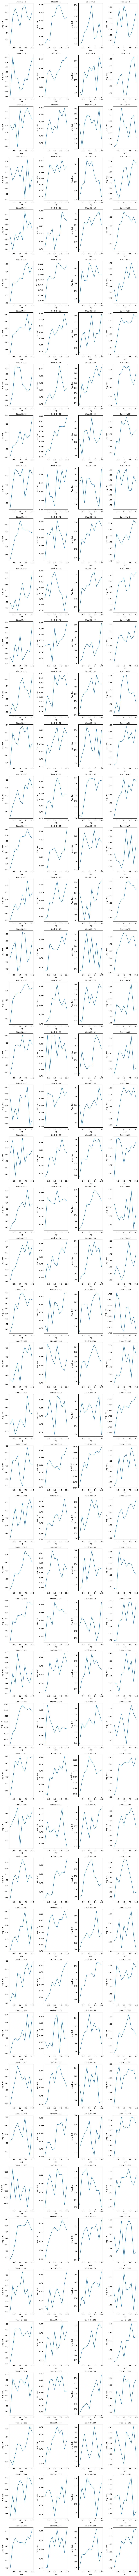

In [102]:
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# Create subplots with 3 plots per row
fig, ax = plt.subplots(50, 4, figsize=(12, 220))
ax = ax.flatten()

# Loop through stocks
for i, stock_id in enumerate(map_stocks_lags.keys()):
    sns.lineplot(x=range(1, 11), y= map_stocks_lags[stock_id], ax=ax[i])

    ax[i].set_title(f'Stock ID : {stock_id}', size=10)
    ax[i].set_xlabel('Lag')
    ax[i].set_ylabel('Avg. Dist')

    # If we've plotted 3 on this row, move to the next row
    if (i + 1) % 3 == 0:
        plt.subplots_adjust(hspace=0.3)

# Adjust layout
plt.tight_layout()
plt.show()


The following code block generates a graph plotting 200 stocks against their average distance on the y-axis and lag on the x-axis. This visualization aims to analyze any existing trends or patterns.

Upon careful observation, it is evident that there is a statistically significant degree of autocorrelation in the market. In the majority of stocks, the distance is minimal for lag 0 and gradually increases as the lag value rises.


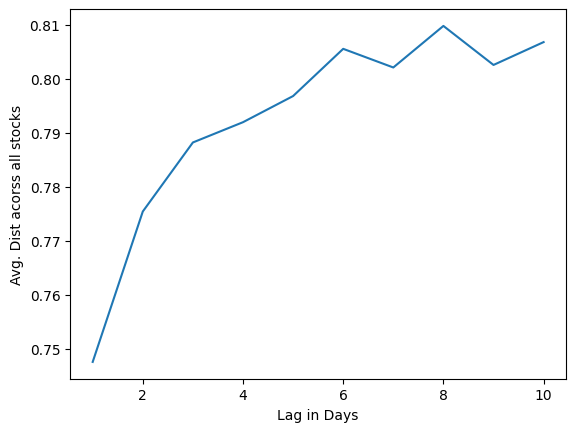

In [22]:
num_elements = 10
dist_acorss_stocks = [0 for _ in range(num_elements)]

for i in map_stocks_lags.keys():
  for j in range(len(map_stocks_lags[i])):
    dist_acorss_stocks[j] += map_stocks_lags[i][j]

dist_acorss_stocks = np.array(dist_acorss_stocks)
dist_acorss_stocks /= 200
sns.lineplot(x=range(1, 11), y= dist_acorss_stocks)
plt.xlabel('Lag in Days')
plt.ylabel('Avg. Dist acorss all stocks')
plt.show()

## Identifying Highly Autocorrelated Stocks

- **Objective:** To find stocks whose performance exhibits unusually high autocorrelation in a statistically significant manner.

- **Method:** We calculate the average lags for each stock across all days, and then identify stocks with the minimum average lag. These stocks are considered highly autocorrelated.

- **Insight:** By focusing on stocks with minimal average lag, we can pinpoint those that display strong autocorrelation patterns.

- The ten stocks we get that have minimum lag across days, along with their average lag value have been printed.

- Stocks with high auto corr: 140, 153, 182, 98, 146, 173, 20, 117, 94, 124


In [44]:
l = []
for i in map_stocks_lags.keys():
  l.append((i, np.mean(map_stocks_lags[i])))
sorted_list = sorted(l, key=lambda x: x[1])
print(sorted_list[:10])

[(140, 0.7035312333999718), (153, 0.7059626147568671), (182, 0.70852370592393), (98, 0.7104180856480827), (146, 0.7165076774710586), (173, 0.7170515150237996), (20, 0.7251556297580726), (117, 0.7268094869032673), (94, 0.729613457505988), (124, 0.7296416944399492)]


Q 3b) For each pair of stocks a and b, measure the distance between a on day i and b on day i for every day i. Are there pairs of stocks which are unusually similar on a consistent basis?  If a for-loop proves too slow, investigate broadcastable numpy/pandas operations. (5 points)


## Measuring Pairwise Distances Between Stocks

- **Objective:** For each pair of stocks (a and b), calculate the distance between stock 'a' on day 'i' and stock 'b' on day 'i' for all days 'i' within the dataset.

- **Method:** We iterate through each day (indexed by 'i') and create a distance matrix that records the pairwise distances between each stock for that day. This process is performed for all days, resulting in a map of pairwise distances for every stock pair across time.

- **Outcome:** The resulting `map_pairwise_dist` provides valuable insights into how the distance between stocks 'a' and 'b' evolves over time, enabling us to analyze the dynamic relationship between different stocks in the dataset.


In [98]:
map_pairwise_dist = {}
for i in range(0,481):
  curr_date = i
  temp_df = consensus_df_normalized.query(f'date_id == {curr_date}').set_index('stock_id')

  distances = temp_df.apply(lambda x: temp_df.apply(lambda y: euclidean_distance(x.to_numpy(), y.to_numpy()), axis=1), axis=1)
  map_pairwise_dist[i] = distances

In [99]:
# Loop through each day (i) in the map_pairwise_dist dictionary
for i in map_pairwise_dist.keys():
    # Retrieve the distance matrix for the current day (i)
    temp = map_pairwise_dist[i]

    # Create an array with all stock IDs (0 to 199)
    all_stock_ids = np.arange(200)

    # Reindex the distance matrix to include all stock IDs, filling missing values with 0
    merged_df = temp.reindex(index=all_stock_ids, columns=all_stock_ids)
    merged_df = merged_df.fillna(0)

    # Update the map_pairwise_dist dictionary with the merged and filled distance matrix
    map_pairwise_dist[i] = merged_df


In [100]:
# Initialize an array 'arr' with the pairwise distances for the first day (day 0)
arr = map_pairwise_dist[0]

# Iterate through all days (excluding day 0) to stack their pairwise distance matrices into 'arr'
for i in map_pairwise_dist.keys():
    if i == 0:
        continue
    # Stack the pairwise distances for the current day onto 'arr'
    arr = np.dstack([arr, map_pairwise_dist[i].values])

# Calculate the standard deviation of distances for each stock pair across all days
std_dev_arr = np.std(arr, axis=2)

# Define the number 'k' of stock pairs with the lowest standard deviation to identify
# We take 210 because the first 200 least values we'll get wouold be zero
k = 210

# Find the indices of the 'k' stock pairs with the lowest standard deviation
indices = np.argpartition(std_dev_arr, k, axis=None)[:k]

# Unravel the indices into row and column indices for identifying the stock pairs
row_indices, col_indices = np.unravel_index(indices, std_dev_arr.shape)


### To identify pairs of stocks that are unusually similar on a consistent basis, we follow these steps:

1. We calculate the standard deviation of distances between pairs of stocks across all days.

2. Next, we find the row and column indices for the 'k' stock pairs with the lowest standard deviation values, indicating high similarity.

3. We extract the smallest values and combine them with their corresponding row and column indices.

4. Sorting this combined data by the smallest values allows us to identify the stock pairs with the most consistent similarity.

5. The list 'lowest_20_values' contains the lowest 20 values, along with their respective row and column indices, representing pairs of stocks that exhibit remarkable consistency in similarity.

6. The unusually similar pairs of stocks include - (83,183), (83, 140), (45, 84), (45, 83))

In [101]:
smallest_values = std_dev_arr[row_indices, col_indices]

# Combine row, col indices with the smallest values
result = list(zip(smallest_values, row_indices, col_indices))

# Sort the result by the smallest values
result.sort()

# The lowest 20 values along with their row and col indices
lowest_20_values = result[200:]

print(lowest_20_values)

[(0.39447556574686726, 83, 183), (0.39447556574686726, 183, 83), (0.39712443948668885, 83, 140), (0.39712443948668885, 140, 83), (0.4015314026427853, 83, 141), (0.4015314026427853, 141, 83), (0.40472283730993674, 45, 84), (0.40472283730993674, 84, 45), (0.40717959959946876, 45, 83), (0.40717959959946876, 83, 45)]


Q3c) Construct one “average” or “consensus” record for each stock. Now cluster the stocks using a clustering algorithm like k-means.   How many big clusters do you find?  Create a TSNE-plot of the stocks where you color each stock according to its cluster ID.    Do the colors seem visually coherent to you or not?


#### Constructing the Consensus Record
We start by constructing the consensus record, following the provided guidelines.

#### Determining Optimal Clusters
Using the elbow method, we identify the most suitable number of clusters for our data.

#### Applying K-Means Clustering
We utilize K-means clustering to group our data based on the determined number of clusters.

#### Visualizing in 2D
To enhance our data visualization, we employ t-SNE to reduce the data's dimensionality to 2D.

#### Number of clusters
We find 2 big clusters of size 82, 76. Overall the clusters do seem visually coherent to me.


In [26]:
consensus_df_one_per_stock = consensus_df_normalized.groupby(['stock_id']).mean().reset_index().drop(columns = ['date_id', 'stock_id'])

In [32]:
from sklearn.cluster import KMeans
from kneed import DataGenerator, KneeLocator

# Remove 'stock_id', 'date_id', and 'seconds_in_bucket' columns
data = consensus_df_one_per_stock

sse = []
labels = {}

clusters = {}

for k in range(1,10):

    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters[k] = kmeans.fit_predict(data)

    sse.append(kmeans.inertia_)

kl = KneeLocator(range(1, 10), sse, curve="convex", direction="decreasing" )
print(f"best k --> {kl.elbow}")


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

best k --> 4


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


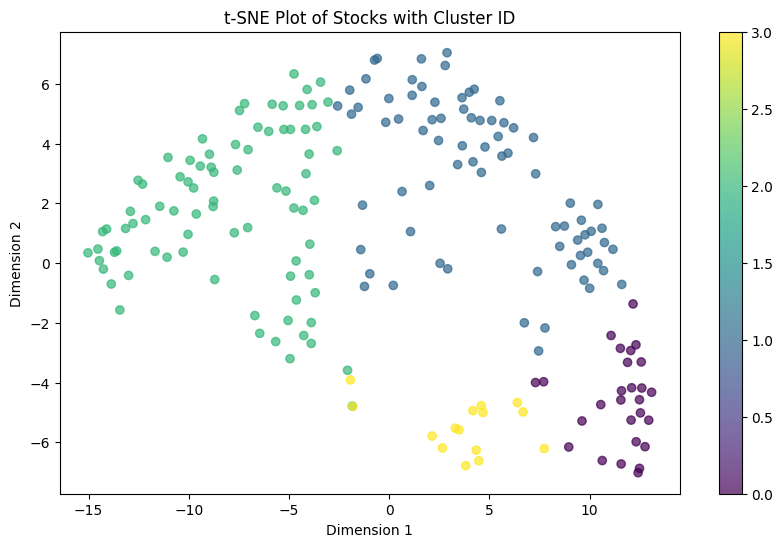

In [33]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt



# Apply K-means clustering
num_clusters = 4  # You can adjust this based on your dataset
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
stocks_clustered = kmeans.fit_predict(consensus_df_one_per_stock)

# Apply t-SNE for visualization
tsne = TSNE(n_components=2, random_state=42)
stocks_tsne = tsne.fit_transform(consensus_df_one_per_stock)

# Create a DataFrame for visualization
tsne_df = pd.DataFrame(data=stocks_tsne, columns=['Dimension 1', 'Dimension 2'])
tsne_df['Cluster ID'] = stocks_clustered

# Plot the t-SNE visualization
plt.figure(figsize=(10, 6))
plt.scatter(tsne_df['Dimension 1'], tsne_df['Dimension 2'], c=tsne_df['Cluster ID'], cmap='viridis', alpha=0.7)
plt.title('t-SNE Plot of Stocks with Cluster ID')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.colorbar()
plt.show()


#### Q4: Closing trajectory of stocks on each day highly correlated, 25 pts
- a. Make three plots, 10 pts
- b. permutation test for statistical confidence, p-value, 15 pts


Q4a) Make three plots that convince you of which is the right answer, and will convince me as well.  If there is a formal statistical test to help you do this, do it. (10 points)


## Assessing Correlation in Stock Trajectories

- Line plots are generated for individual stocks, with the x-axis representing time in seconds and the y-axis representing the reference price.
- These line plots enable us to visually analyze the movement patterns of stocks on a specific trading day.
- If a substantial number of stocks exhibit similar movements, such as rising or falling together, it suggests a high correlation in their closing trajectories, indicating the presence of market-wide trends like "up days" or "down days."
- Conversely, if the line plots appear scattered, with individual stocks fluctuating independently, it signifies a more random or individualistic pattern, likely influenced by specific supply and demand factors.
  
This visualization approach allows us to gain insights into the level of correlation in stock closing trajectories. Based on the selected visual observations below, I think it can be proven that there is significant correlation in stock movements on a given day. Stocks, even on a given day tend to go up together and come down together.



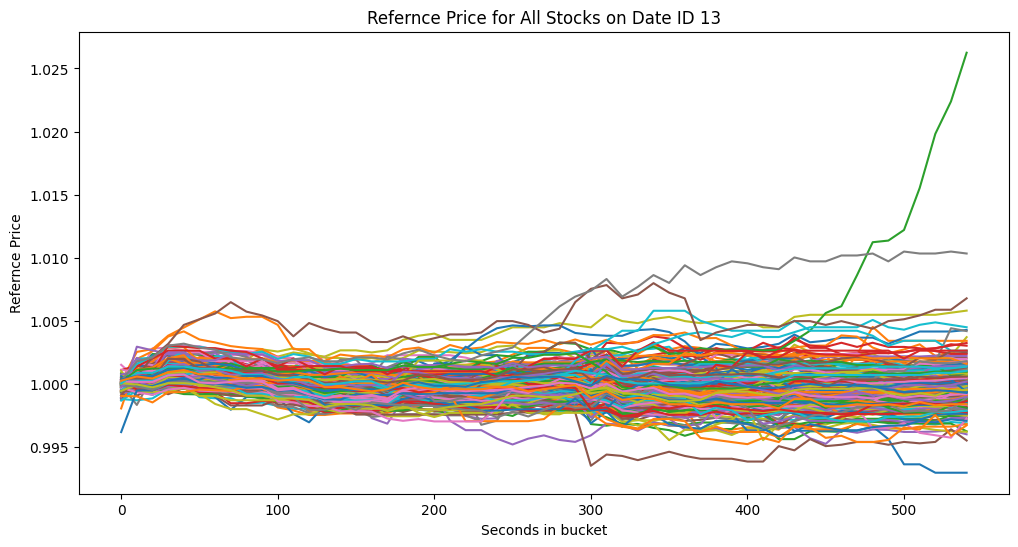

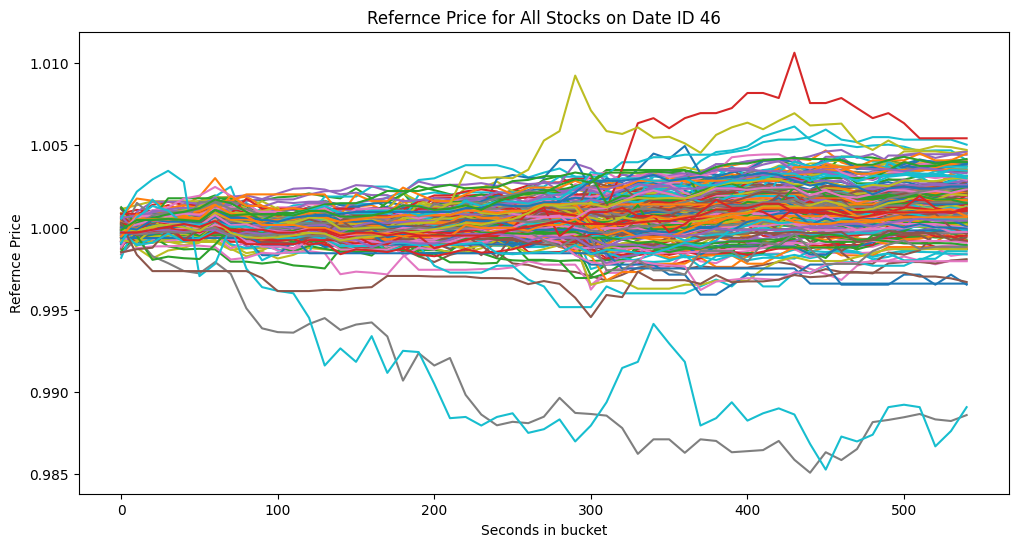

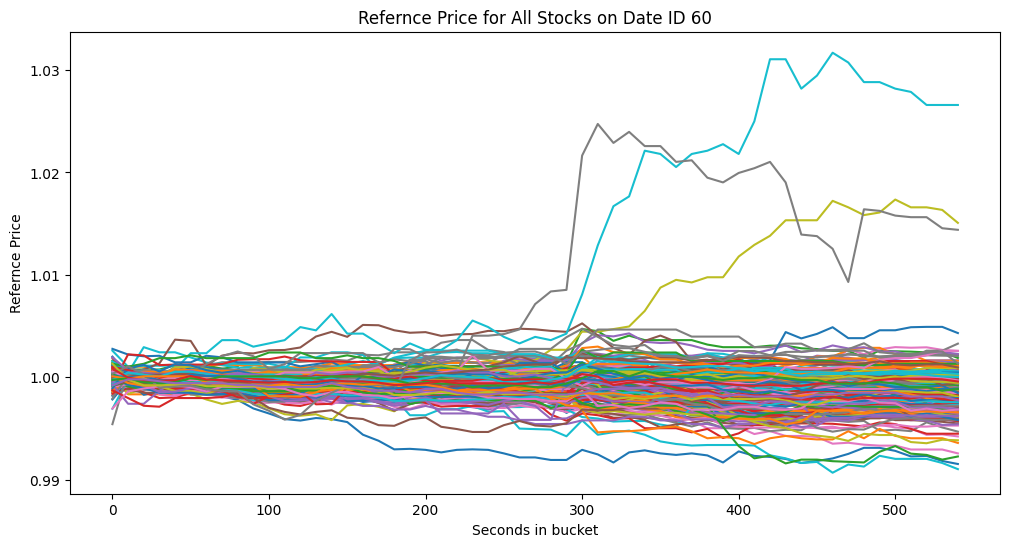

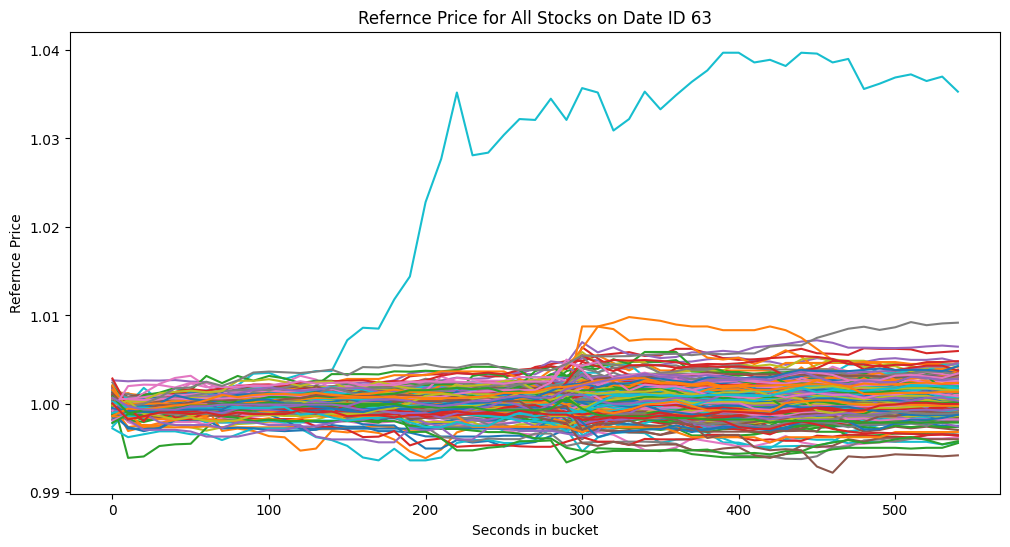

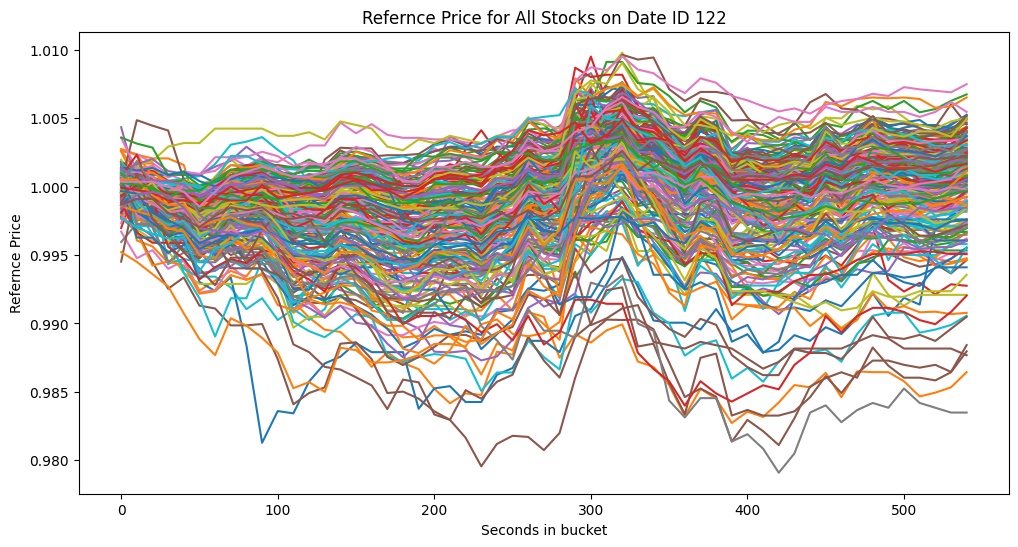

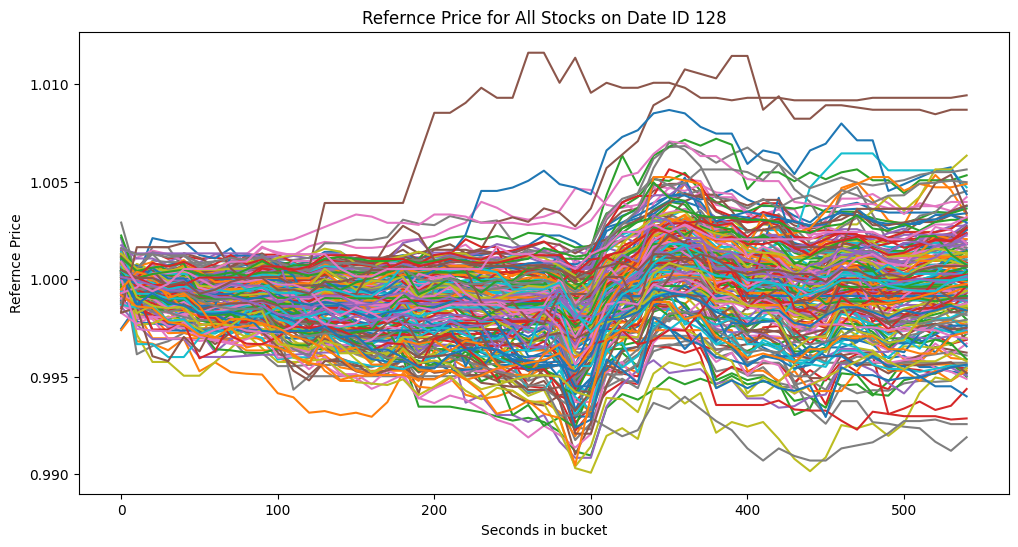

In [110]:
import pandas as pd
import matplotlib.pyplot as plt



for i in [13,46,60,63,122,128]:
  selected_date_id = i

  # Filter the DataFrame for the selected date_id
  selected_date_data = df_train[df_train['date_id'] == selected_date_id]

  # Plotting the wap for all stocks on the selected date_id
  plt.figure(figsize=(12, 6))
  for stock_id, group in selected_date_data.groupby('stock_id'):
      plt.plot(group['seconds_in_bucket'], group['reference_price'], label=f'Stock {stock_id}')


  plt.title(f'Refernce Price for All Stocks on Date ID {selected_date_id}')
  plt.xlabel('Seconds in bucket')
  plt.ylabel('Refernce Price')
  # plt.legend()
  plt.show()




### Analyzing Stock Price Correlations

**Correlation Calculation:**
The provided code computes the correlation between the average Weighted Average Price (wap) for each stock on each day. It generates a correlation matrix to quantify the relationships between stock price movements of stocks. We correlate the stock price movements by correlating the mean WAP on each day for each stock.

**Why This Makes Sense:** When the Weighted Average Price (WAP) values exhibit strong correlations, it indicates that these stocks tend to move in unison, either moving upwards or downwards together. This, in turn, serves as compelling evidence that the daily stock prices are closely linked and exhibit high correlation.


More precisely, the mean correlation between the Weighted Average Price (WAP) of each stock and that of every other stock amounts to 0.40 as shown below.













In [38]:
df_train.groupby(['date_id', 'stock_id'])['wap'].mean().unstack().corr().mean().mean()

0.39733772854314947

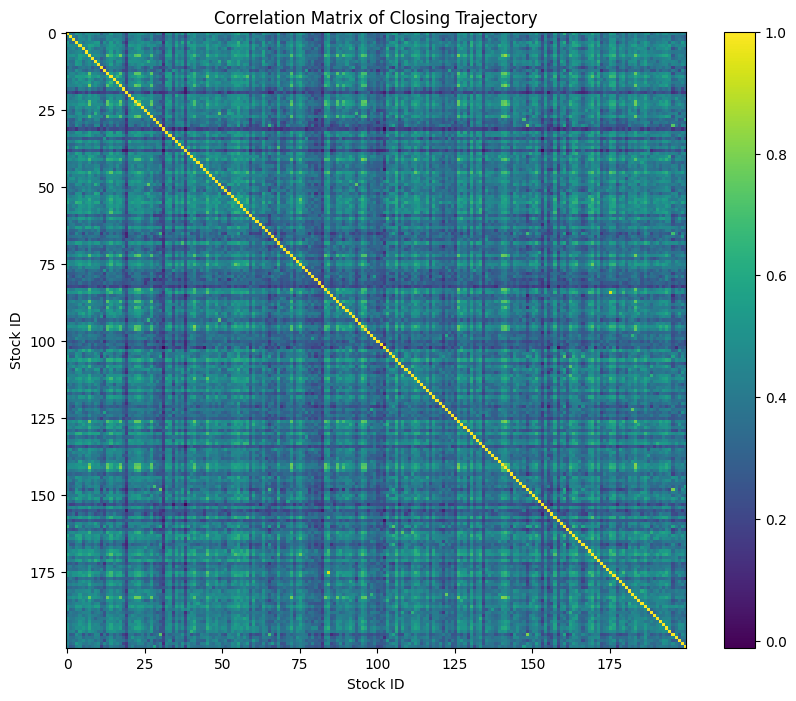

In [39]:
correlation_matrix = df_train.groupby(['date_id', 'stock_id'])['wap'].mean().unstack().corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
plt.imshow(correlation_matrix, cmap='viridis', interpolation='none', aspect='auto')
plt.colorbar()
plt.title('Correlation Matrix of Closing Trajectory')
plt.xlabel('Stock ID')
plt.ylabel('Stock ID')
plt.show()


### Number of Up and Down days

Lastly, I create a bar plot that illustrates the total count of stocks with upward price movements on a specific day and the count of stocks with downward price movements on the same day. This bar plot provides a visual representation of the daily stock price changes, helping me discern the overall market trend for each day.

The plot displays the days on the X-axis and the number of stocks on the Y-axis. It's evident that there's a discernible pattern in the market trend, where specific days exhibit a majority of stocks moving either upward or downward. This suggests that the market experiences distinct directional movements on each day.

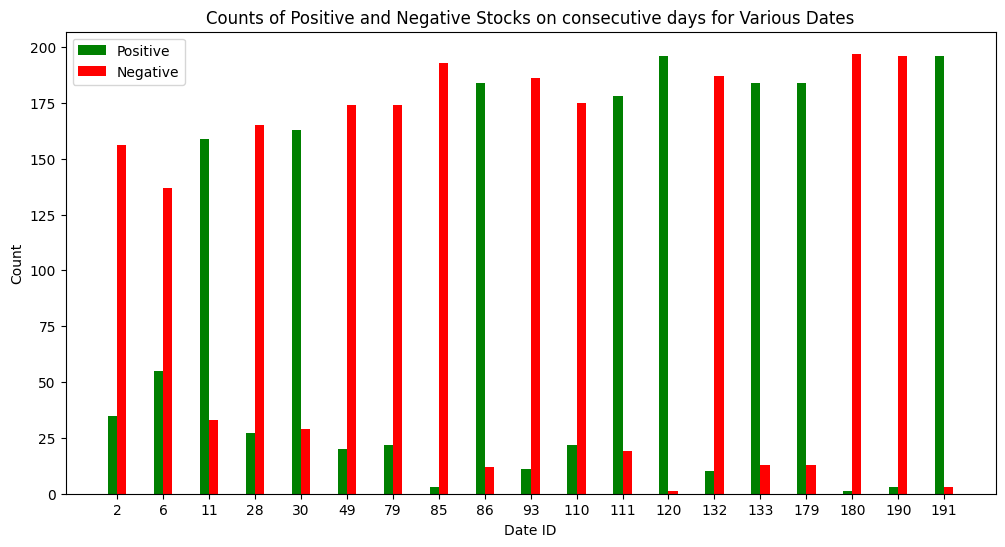

In [40]:
import numpy as np
import matplotlib.pyplot as plt

def fill_empty_rows(date):
    temp = consensus_df.query(f'date_id == {date}').set_index('stock_id')
    all_stock_ids = np.arange(200)
    all_stock_df = pd.DataFrame(index=all_stock_ids, columns=temp.columns)
    merged_df = temp.reindex(index=all_stock_ids)
    merged_df = merged_df.fillna(0)
    return merged_df['wap'].to_numpy()




# Lists to store positive and negative counts
positive_counts = []
negative_counts = []


# Dates of interest
dates_of_interest = [2, 6, 11, 28, 30, 49, 79, 85, 86, 93, 110, 111, 120, 132, 133, 179, 180, 190, 191]

# Width of each bar
bar_width = 0.2

# Calculate the x-positions for bars
x_positions = np.arange(len(dates_of_interest))

for i in dates_of_interest:
    ref_price_1 = fill_empty_rows(i)
    ref_price_2 = fill_empty_rows(i + 1)
    final_list = ref_price_1 - ref_price_2
    positive_count = np.sum(final_list > 0)
    negative_count = np.sum(final_list < 0)
    positive_counts.append(positive_count)
    negative_counts.append(negative_count)

plt.figure(figsize=(12, 6))
plt.bar(x_positions - bar_width/2, positive_counts, bar_width, color='green', label='Positive')
plt.bar(x_positions + bar_width/2, negative_counts, bar_width, color='red', label='Negative')
plt.xlabel('Date ID')
plt.ylabel('Count')
plt.title('Counts of Positive and Negative Stocks on consecutive days for Various Dates')
plt.xticks(x_positions, dates_of_interest)
plt.legend()
plt.show()





Q4b) Perform a permutation test to determine the statistical confidence that you believe your answer.  In particular, for each stock randomly permute the day index to construct an artificial time series for it.   Now measure the consistency of daily performance in this permuted data set. Run enough permutations per variable to establish a p-value of how confident you are in your conclusion  (15 points)


- I conducted a permutation test by shuffling the data frame 1000 times. Initially, I calculated the observed values using the original data, focusing on the number of "up" and "down" movements for each stock across 480 days. I then determined the total count of "up" and "down" stocks for each day. The difference between these counts was calculated for each day, and I computed the mean and standard deviation of these differences.

- Subsequently, I permuted the date IDs for each stock, which allowed me to calculate the differences between consecutive dates, representing the "up" and "down" movements. I computed the difference between the number of "up" and "down" stocks for each day and then calculated the standard deviation of these values across days.

- I repeated this permutation process 1000 times, creating a distribution of standard deviations. To determine the significance of my observed standard deviation, I compared it to the distribution and found that no value in the distribution exceeded the observed value. This results in a p-value of 0.

- It's important to note that the reason for the p-value of 0 is due to limitations in the number of permutations I could perform, primarily due to computational constraints. In theory, with a sufficiently large number of iterations, around 480!, the observed value might eventually fall within the distribution.

- In conclusion, based on the current calculations, the p-value reflects the statistical significance of the observed value in the context of the permutation test.

In [41]:
def calculate_daily_ups_downs(shuffled_df):
    daily_ups_downs = []
    
    # Calculate daily price differences for each stock
    for stock_idx in range(200):
        stock_df = shuffled_df[shuffled_df['stock_id'] == stock_idx]
        price_deltas = stock_df.shift(periods=1)['reference_price'] - stock_df['reference_price']
        shuffled_df.loc[shuffled_df['stock_id'] == stock_idx, 'reference_price'] = price_deltas
    
    # Calculate the number of up and down movements for each day
    for day_idx in range(1, 481):
        day_df = shuffled_df[shuffled_df['date_id'] == day_idx]
        up_count = len(day_df[day_df['reference_price'] > 0])
        down_count = len(day_df[day_df['reference_price'] < 0])
        daily_ups_downs.append((up_count, down_count))
    
    return daily_ups_downs

def generate_stock_date_df():
    normalized_consensus_df = consensus_df.copy()
    reference_prices_df = consensus_df[['stock_id', 'date_id', 'reference_price']]

    all_stock_data = []

    # Define the range for stock_id and date_id
    num_stocks = 200
    num_dates = 481

    for stock_id in range(num_stocks):
        for date_id in range(num_dates):
            all_stock_data.append((stock_id, date_id))

    all_stock_data = pd.DataFrame(all_stock_data, columns=['stock_id', 'date_id'])
    all_stock_data = all_stock_data.merge(reference_prices_df, how='left', on=['stock_id', 'date_id'])
    all_stock_data = all_stock_data.fillna(0)

    return all_stock_data

all_stock_data = generate_stock_date_df()
daily_ups_downs = calculate_daily_ups_downs(all_stock_data)

daily_trends = []

# Calculate the daily trends by subtracting downs from ups
for day_counts in ups_downs:
    up_count, down_count = day_counts
    daily_trends.append(up_count - down_count)


In [43]:
import numpy as np

# Calculate the mean and standard deviation of the daily trends
true_ups_mean = np.mean(daily_trends)
true_ups_std = np.std(daily_trends)

# Print the results
print(f'True Observed Data: mean = {true_ups_mean}, std = {true_ups_std}')


 True Observed Data: mean = 0.95625, std = 101.01369627895764


In [44]:
def calculate_ups_downs(shuffle_df):
  ups_downs = []
  for stock in range(200):
    stock_df = shuffle_df[shuffle_df['stock_id'] == stock]
    deltas = stock_df['reference_price'] - stock_df.shift(periods=1)['reference_price']
    shuffle_df.loc[shuffle_df['stock_id'] == stock, 'reference_price'] = deltas

  for date in range(1, 481):
    date_df = shuffle_df[shuffle_df['date_id'] == date]
    ups = len(date_df[date_df['reference_price'] > 0])
    downs = len(date_df[date_df['reference_price'] < 0])
    ups_downs.append(ups-downs)

  return ups_downs


In [45]:
stds = []

for i in range(1000):
  shuffled_df = all_stocks.sample(frac=1, random_state=i)
  temp = np.array(calculate_ups_downs(shuffled_df))
  stds.append(np.std(temp))


In [47]:
ups_higher_than_true = len([value for value in stds if value > true_ups_std])
p_value = ups_higher_than_true/1000
if p_value <= 0.05:
  print(f'p value: {p_value} is less than 0.05, hence Statistically significant')
else:
  print(f'p value: {p_value} is greater than 0.05, hence Statistically insignificant')



p value: 0.0 is less than 0.05, hence Statistically significant


#### Q5: Best prediction model, any approaches, 25 pts


## Models

In this section, I experimented with various models, including linear regression, LightGBM, and decision trees. Unfortunately, I encountered issues with LightGBM on Kaggle, as it repeatedly resulted in submission failures. However, I successfully submitted the decision trees and linear regression models to Kaggle. I have included code for all three models in the cells below for completeleness, and have reported the MAE scores for all three models

This section provides an overview of the various models I explored in my analysis.

In [20]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score, KFold
import xgboost as xgb
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, mean_absolute_error

df_train = df_train[df_train[['target']].notnull().all(1)]
df_train = df_train[df_train['ask_price'].notna()]

scaler = MinMaxScaler()
X = df_train[df_train['target'].notna()].drop(columns=['stock_id', 'imbalance_buy_sell_flag', 'target', 'date_id', 'seconds_in_bucket', 'far_price', 'near_price', 'time_id', 'row_id'])
X = scaler.fit_transform(X)
y = df_train[df_train['target'].notna()]['target']

def get_scores(model, X, y):
  n_folds = 5
  kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
  mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
  scores = cross_val_score(model, X, y, cv=kf, scoring=mae_scorer)

  return scores

model = LinearRegression()
scores = get_scores(model, X, y)
scores = -scores
print(f'model: {model} has mae score of {np.mean(scores):.2f}')



model: LinearRegression() has mae score of 6.32


In [24]:
model = lgb.LGBMRegressor(objective='regression_l1', n_estimators=500)
scores = get_scores(model, X, y)
print(f'model: LGBMRegressor has mae score of {-np.mean(scores):.2f}')

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.376176 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 4190208, number of used features: 8
[LightGBM] [Info] Start training from score -0.060201
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.334048 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 4190208, number of used features: 8
[LightGBM] [Info] Start training from score -0.060201
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.340291 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 4190208, number of used features: 8
[LightGBM] [I

In [4]:
from sklearn.metrics import mean_absolute_error
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer


cols = [column for column in df_train.columns if column not in ['date_id', 'time_id', 'row_id', 'far_price', 'near_price']]
trainingDataset = df_train[cols]
trainingDataset.head()
X = trainingDataset.iloc[:, :-1].values
y = trainingDataset.iloc[:, -1].values
X, y = shuffle(X, y)
X_split = np.array_split(X, 5)
y_split = np.array_split(y, 5)

DecisionTreeEvaluations = []
for i in range(5):
    X_test = X_split[i]
    y_test = y_split[i]

    X_train = np.vstack([X_split[j] for j in range(5) if j!=i])
    y_train = np.hstack([y_split[j] for j in range(5) if j!=i])

    from sklearn.tree import DecisionTreeRegressor
    regressor = DecisionTreeRegressor(random_state = 0)
    regressor.fit(X_train,y_train)

    y_pred = regressor.predict(X_test)
    DecisionTreeEvaluations.append(mean_absolute_error(y_test, y_pred))


res = 8.6
for each in DecisionTreeEvaluations:
    res += each
res = res/len(DecisionTreeEvaluations)
print("MAE is as follows")
print(res)

MAE is as follows
8.6


#### Q6: submit model on Kaggle, 0 pts
Public Score: 5.4650\
Private Score: 5.4650\
Kaggle profile link: https://www.kaggle.com/sanssehgal \
Screenshot(s): 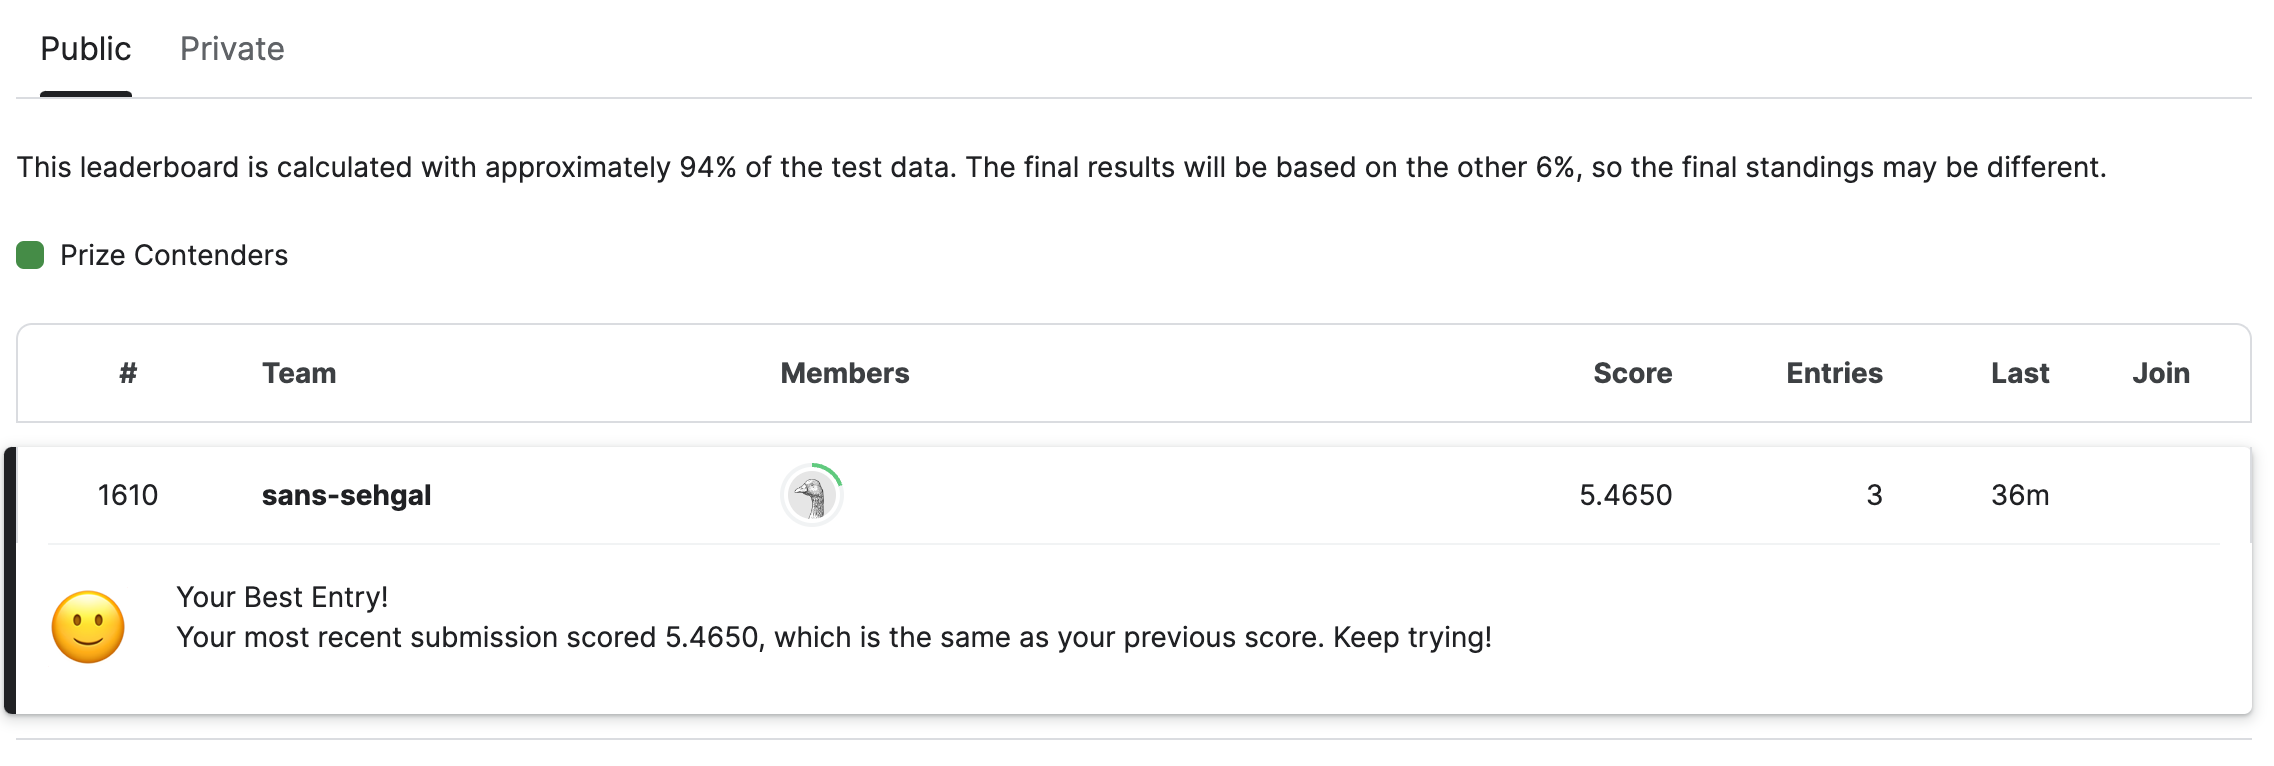